In [1]:
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re

import matplotlib.ticker as mticker

import matplotlib.colors as mcolors
#palette = list(mcolors.TABLEAU_COLORS.keys())
#palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid")
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [2]:
# CAA was reconstituted in 400uL instead of 500uL
# CAA peak will then be 5/4 times what it should be
## RR will then be 4/5 of what it should be
# Correction factor: 5/4

def RR2Asp(RR):
    return(54.611* ((RR * 5/4)**1.0578))
def RR2Asn(RR):
    return(60.033* ((RR * 5/4)**0.9177))

In [3]:
### Read measurements

annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Asp-levels-post-UCPH.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['Response Ratio']) != 0:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
  
        metab_dict_mes[k]['Sample_name'] = metab_dict_mes[k]['Sample ID']
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['Dilution_factor']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'Flag Details'], axis=1)

In [4]:
metab_dict_mes['Adenine pos']

,Compound,RT,Sample ID,Response,Formula,Response Ratio,Sample_name,UCPH,Dilution_factor,Proliferation_rate,Proliferation_rate_stdev,Cell_line,Salvage_mix
0,Adenine pos,5.82,UC01,13901657,C5H5N5,0,UC01,10.000000,0.025,0.977338,0.010701,143B 2xGOT KO,No
1,Adenine pos,5.82,UC02,17173956,C5H5N5,0,UC02,10.000000,0.025,0.977338,0.010701,143B 2xGOT KO,No
2,Adenine pos,5.82,UC03,16590204,C5H5N5,0,UC03,5.000000,0.025,0.996368,0.009339,143B 2xGOT KO,No
3,Adenine pos,5.82,UC04,20367555,C5H5N5,0,UC04,5.000000,0.025,0.996368,0.009339,143B 2xGOT KO,No
4,Adenine pos,5.82,UC05,17379645,C5H5N5,0,UC05,2.500000,0.025,1.285446,0.041143,143B 2xGOT KO,No
5,Adenine pos,5.82,UC06,19310370,C5H5N5,0,UC06,2.500000,0.025,1.285446,0.041143,143B 2xGOT KO,No
6,Adenine pos,5.82,UC07,17576691,C5H5N5,0,UC07,1.250000,0.025,1.325634,0.046311,143B 2xGOT KO,No
7,Adenine pos,5.82,UC08,20152278,C5H5N5,0,UC08,1.250000,0.025,1.325634,0.046311,143B 2xGOT KO,No
8,Adenine pos,5.82,UC09,19889663,C5H5N5,0,UC09,0.625000,0.025,1.305621,0.030116,143B 2xGOT KO,No
9,Adenine pos,5.82,UC10,29607102,C5H5N5,0,UC10,0.625000,0.025,1.305621,0.030116,143B 2xGOT KO,No


In [5]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values

In [6]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)

#df['Aspartate conc'] = RR2Asp(df['Aspartate neg'].values) / df['Dilution_factor'].values
#df['Asparagine conc'] = RR2Asn(df['Asparagine pos'].values) / df['Dilution_factor'].values

In [7]:
# Normalize metabolites except Asp:
df_norm = copy.deepcopy(df)
mask0 = df_norm['UCPH'] == 0
for col in df.columns:
    if col == 'Aspartate conc':
        continue
    if 'neg' in col or 'pos' in col or 'conc' in col or 'NAD-NADH' in col:
        df_norm.loc[:, col] = df_norm[col].values / np.mean(df_norm.loc[mask0, col])

In [8]:
df_mean = df.groupby(['UCPH']).mean().reset_index()
df_stdev = df.groupby(['UCPH']).std().reset_index()

df_norm_mean = df_norm.groupby(['UCPH']).mean().reset_index()
df_norm_stdev = df_norm.groupby(['UCPH']).std().reset_index()

In [9]:
df_norm_mean['Aspartate conc']

0    43268.613913
1    45217.809307
2    41189.619201
3    40737.884135
4    37696.081218
5    29407.195845
6    20712.286313
7     9589.627506
8     7387.431192
Name: Aspartate conc, dtype: float64

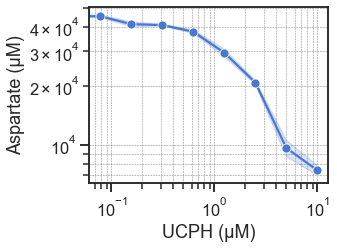

In [219]:
### Aspartate as a function of UCPH ###

fig, ax1 = plt.subplots(1, 1, figsize=(5, 3.8))

g1 = sns.lineplot(ax=ax1, data=df, x='UCPH', y='Aspartate conc', markers=True, marker='o')
g1.set(yscale="log", xscale="log");
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g1.set(ylabel='Aspartate (μM)', xlabel='UCPH (μM)')

plt.tight_layout()
fig.savefig('UCPH_vs_Asp.pdf')

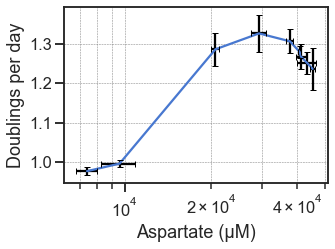

In [220]:
### Proliferation rate as a function of Aspartate ###

fig, ax2 = plt.subplots(1, 1, figsize=(5, 3.8))
g2 = sns.lineplot(ax=ax2, data=df_mean, x='Aspartate conc', y='Proliferation_rate', 
                 markers=True, dashes=False)
g2.errorbar(y=df_mean['Proliferation_rate'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_mean['Proliferation_rate_stdev'].values, fmt='none', color='black', capsize=3)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g2.set(xscale="log")
#g2.set(ylim=[0,1.4]);
#g2.set(xlim=[5000, 50000]);

g2.set(xlabel='Aspartate (μM)', ylabel='Doublings per day')

### Stupid hack to get rid of overlapping label:
g2.xaxis.get_minorticklabels()[17].set_visible(False)



plt.tight_layout()
fig.savefig('Asp_vs_Proliferation.pdf')

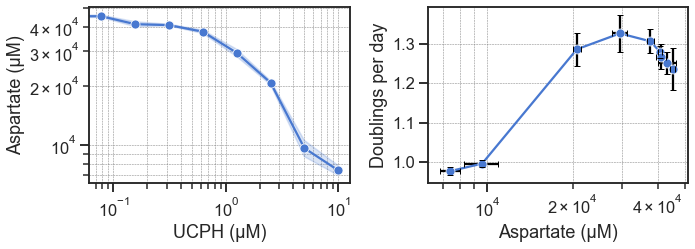

In [162]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.8))


g1 = sns.lineplot(ax=ax1, data=df, x='UCPH', y='Aspartate conc', markers=True, marker='o')
g1.set(yscale="log", xscale="log");
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g1.set(ylabel='Aspartate (μM)', xlabel='UCPH (μM)')




g2 = sns.lineplot(ax=ax2, data=df_mean, x='Aspartate conc', y='Proliferation_rate', 
                 markers=True, marker='o')
g2.errorbar(y=df_mean['Proliferation_rate'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_mean['Proliferation_rate_stdev'].values, fmt='none', color='black', capsize=3)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)


g2.set(xscale="log");
#g2.set(ylim=[0,1.4]);

g2.set(xlabel='Aspartate (μM)', ylabel='Doublings per day')

### Stupid hack to get rid of overlapping label:
g2.xaxis.get_minorticklabels()[17].set_visible(False)



plt.tight_layout()
fig.savefig('combined-UCPH-Asp-prolif.pdf')

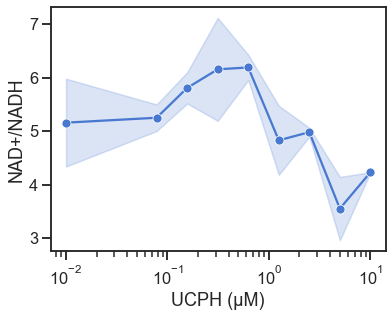

In [202]:
### NAD/NADH ratio as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("UCPH_vs_NAD-NADH.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df, x='UCPH', y='NAD-NADH', markers=True, marker='o')
g.set(xscale="log");

plt.ylabel('NAD+/NADH')#, size=12);
plt.xlabel('UCPH (μM)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

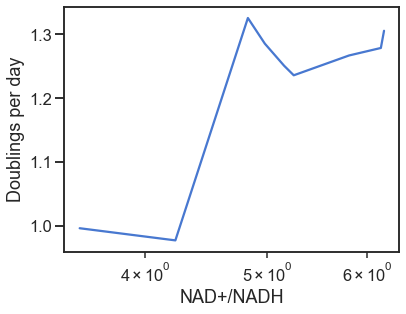

In [165]:
### Proliferation rate as a function of NAD+/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Proliferation.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean, x='NAD-NADH', y='Proliferation_rate', markers=True, dashes=False)

#g.errorbar(y=df_mean['Proliferation_rate'].values, x=df_mean['NAD-NADH'].values, xerr=df_stdev['NAD-NADH'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");

plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('NAD+/NADH')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

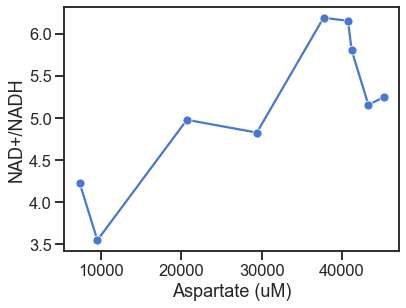

In [168]:
### Aspartate as a function of NAD/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Asp.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean, y='NAD-NADH', x='Aspartate conc', markers=True, marker='o')

#g.errorbar(y=df_mean['Aspartate conc'].values, x=df_mean['NAD-NADH'].values, yerr=df_stdev['Aspartate conc'].values, xerr=df_stdev['NAD-NADH'].values, fmt='none', color='black', capsize=5)
#g.set(xscale="log");


plt.xlabel('Aspartate (μM)')#, size=12);
plt.ylabel('NAD+/NADH')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

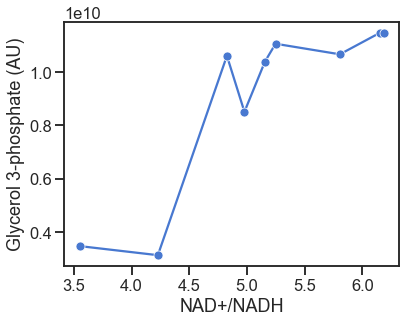

In [173]:
### Glycerol 3-phosphate as a function of NAD/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_G3P.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean, x='NAD-NADH', y='Glycerol 3-phosphate neg', markers=True, marker='o')

#g.errorbar(y=df_mean[mask1]['Glycerol 3-phosphate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Glycerol 3-phosphate neg'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)
#g.set(xscale="log");


plt.ylabel('Glycerol 3-phosphate (AU)')#, size=12);
plt.xlabel('NAD+/NADH')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

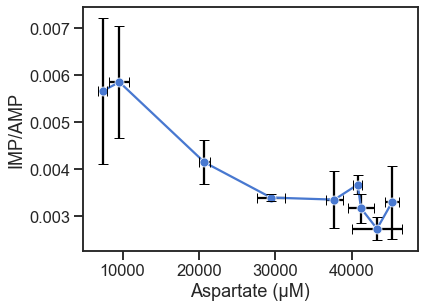

In [221]:
### IMP/AMP ratio as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_IMP-AMP_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, x='Aspartate conc', y='IMP-AMP', markers=True, marker='o')

g.errorbar(y=df_mean['IMP-AMP'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['IMP-AMP'].values, fmt='none', color='black', capsize=5)
#g.set(xscale="log");


plt.ylabel('IMP/AMP')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

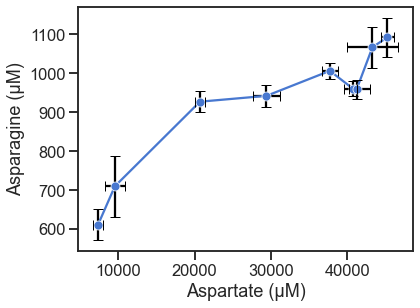

In [226]:
### Asparagine as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Asn.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, x='Aspartate conc', y='Asparagine conc', markers=True, marker='o')

g.errorbar(y=df_mean['Asparagine conc'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['Asparagine conc'].values, fmt='none', color='black', capsize=5)


plt.ylabel('Asparagine (μM)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

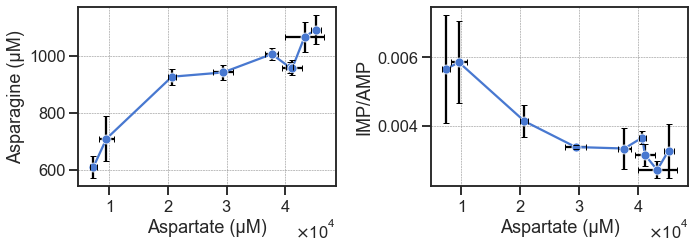

In [243]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3.8))


g1 = sns.lineplot(ax=ax1, data=df_mean, x='Aspartate conc', y='Asparagine conc', markers=True, marker='o')

g1.errorbar(y=df_mean['Asparagine conc'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['Asparagine conc'].values, fmt='none', color='black', capsize=3)
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g1.set(ylabel='Asparagine (μM)', xlabel='Aspartate (μM)')
g1.ticklabel_format(axis='x', style='sci', scilimits=[0, 0], useMathText=True)


g2 = sns.lineplot(ax=ax2, data=df_mean, x='Aspartate conc', y='IMP-AMP', markers=True, marker='o')

g2.errorbar(y=df_mean['IMP-AMP'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['IMP-AMP'].values, fmt='none', color='black', capsize=3)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)

g2.set(xlabel='Aspartate (μM)', ylabel='IMP/AMP')
g2.ticklabel_format(axis='x', style='sci', scilimits=[0, 0], useMathText=True)

### Stupid hack to get rid of overlapping label:
#g2.xaxis.get_minorticklabels()[17].set_visible(False)


plt.tight_layout()
fig.savefig('combined-Asp-fates.pdf')

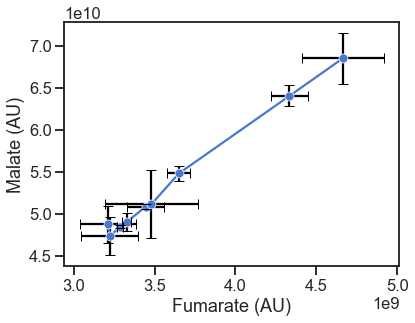

In [177]:
### Malate as a function of Fumarate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Fum_vs_Mal_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, y='Malate neg', x='Fumarate neg', markers=True, marker='o')

g.errorbar(y=df_mean['Malate neg'].values, x=df_mean['Fumarate neg'].values, xerr=df_stdev['Fumarate neg'].values, yerr=df_stdev['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)')#, size=12);
plt.xlabel('Fumarate (AU)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

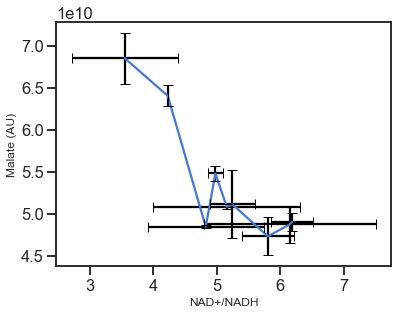

In [178]:
### Malate as a function of NAD/NADH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Mal_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, y='Malate neg', x='NAD-NADH', markers=True, dashes=False)

g.errorbar(y=df_mean['Malate neg'].values, x=df_mean['NAD-NADH'].values, xerr=df_stdev['NAD-NADH'].values, yerr=df_stdev['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)', size=12);
plt.xlabel('NAD+/NADH', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

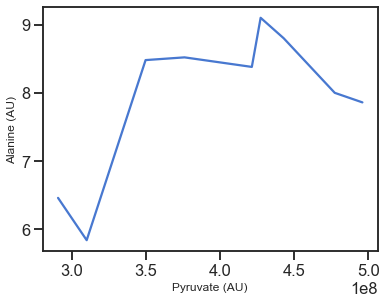

In [179]:
### Alanine as a function of Pyruvate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Ala_vs_Pyr_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean, y='Alanine pos', x='Pyruvate neg', markers=True, dashes=False)

plt.ylabel('Alanine (AU)', size=12);
plt.xlabel('Pyruvate (AU)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [358]:
'gfds neg'[-4:]

' neg'

In [374]:
# Prepare for plotting:
df_mean_melt = pd.melt(df_norm_mean, id_vars=['UCPH', 'Proliferation_rate', 'Aspartate conc'], var_name='Metabolite', value_name='value')
df_mean_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_mean_melt['Metabolite'].values]

df_stdev_melt = pd.melt(df_norm_stdev, id_vars=['UCPH', 'Proliferation_rate', 'Aspartate conc'], var_name='Metabolite', value_name='value')
df_stdev_melt['Metabolite'] = [m[:-4] if m[-3:] == 'neg' or m[-3:] == 'pos' else m for m in df_stdev_melt['Metabolite'].values]

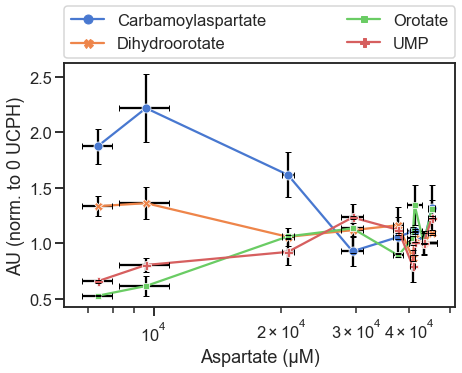

In [375]:
### Pyrimidine synthesis is blocked at DHODH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 4.5))
metab_list = ['Carbamoylaspartate', 'Dihydroorotate', 'Orotate', 'UMP']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g1 = sns.lineplot(data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g1.set(xscale="log");
g1.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')

g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

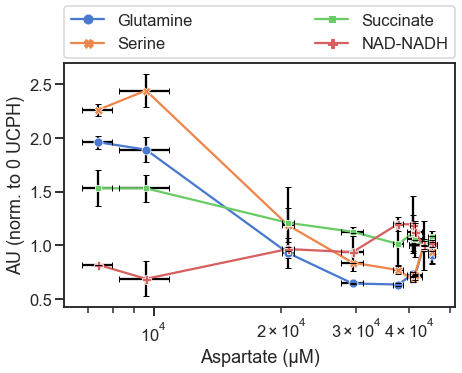

In [376]:
### Pyrimidine synthesis is blocked at DHODH ###

#pdf = matplotlib.backends.backend_pdf.PdfPages("DHODH_vs_Asp.pdf")
fig = plt.figure(figsize=(7, 4.5))
metab_list = ['Glutamine', 'Serine', 'Succinate', 'NAD-NADH']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g1 = sns.lineplot(data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g1.set(xscale="log");
g1.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')

g1.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)

#pdf.savefig(fig)
plt.show(fig)
#plt.close(fig)
#pdf.close()

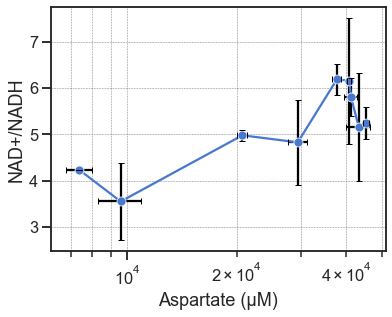

In [267]:
### Aspartate as a function of NAD/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Asp.pdf")
fig = plt.figure(figsize=(6, 4.5))
#mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean, y='NAD-NADH', x='Aspartate conc', markers=True, marker='o')
g.errorbar(y=df_mean['NAD-NADH'].values, x=df_mean['Aspartate conc'].values, xerr=df_stdev['Aspartate conc'].values, yerr=df_stdev['NAD-NADH'].values, fmt='none', color='black', capsize=3)
#g.set(xscale="log");
g.set(xlabel='Aspartate (μM)', ylabel='NAD+/NADH')
g.set(xscale="log");
g.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
### Stupid hack to get rid of overlapping label:
g.xaxis.get_minorticklabels()[17].set_visible(False)
#g.ticklabel_format(axis='y', style='plain')

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

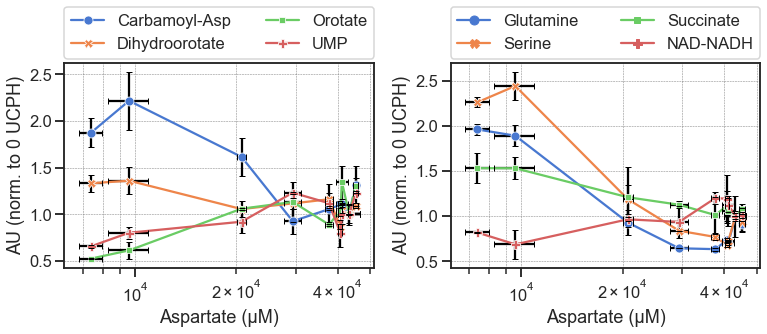

In [382]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'width_ratios': [1, 1]})


metab_list = ['Carbamoylaspartate', 'Dihydroorotate', 'Orotate', 'UMP']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g1 = sns.lineplot(ax=ax1, data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g1.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g1.set(xscale="log");
g1.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')
### Stupid hack to get rid of overlapping label:
g1.xaxis.get_minorticklabels()[17].set_visible(False)
g1.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g1.legend(['Carbamoyl-Asp','Dihydroorotate', 'Orotate', 'UMP'], bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)





metab_list = ['Glutamine', 'Serine', 'Succinate', 'NAD-NADH']
mask = df_mean_melt['Metabolite'].isin(metab_list)
g2 = sns.lineplot(ax=ax2, data=df_mean_melt[mask], y='value', x='Aspartate conc', markers=True, dashes=False, hue='Metabolite', style='Metabolite')

g2.errorbar(y=df_mean_melt[mask]['value'].values, x=df_mean_melt[mask]['Aspartate conc'].values, yerr=df_stdev_melt[mask]['value'].values, xerr=df_stdev_melt[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3)
g2.set(xscale="log");
g2.set(xlabel='Aspartate (μM)', ylabel='AU (norm. to 0 UCPH)')
### Stupid hack to get rid of overlapping label:
g2.xaxis.get_minorticklabels()[17].set_visible(False)
g2.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
g2.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", mode="expand", borderaxespad=0, ncol=2)



plt.tight_layout()
fig.savefig('combined-ETCinhib.pdf')